Kode ini berfungsi untuk mengimpor berbagai pustaka (library) yang dibutuhkan dalam proses pengolahan citra, ekstraksi fitur tekstur, pemodelan klasifikasi, evaluasi model, dan visualisasi data. Beberapa pustaka seperti `cv2` untuk pengolahan gambar, `matplotlib` dan `seaborn` untuk visualisasi grafik, serta `numpy` dan `pandas` untuk manipulasi data dan array. Selain itu, pustaka `sklearn` digunakan untuk membagi dataset menjadi data latih dan uji, membuat model klasifikasi seperti Random Forest, SVM, dan KNN, serta untuk menghitung metrik evaluasi performa model seperti akurasi, presisi, recall, f1-score, dan confusion matrix. Pustaka `skimage.feature` digunakan untuk ekstraksi fitur tekstur dengan GLCM, dan `scipy.stats` digunakan untuk menghitung entropi sebagai fitur tambahan.


In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

Kode ini berfungsi untuk memuat dan memproses gambar dari folder dataset yang berisi sub-folder sebagai label kelas. Setiap gambar dibaca, diubah ukurannya menjadi 224x224 piksel, dikonversi ke grayscale, lalu disimpan dalam list `data`. Nama sub-folder disimpan sebagai `labels`, dan nama file gambar disimpan di `file_name`. Terakhir, ketiga list dikonversi menjadi array NumPy untuk keperluan pemrosesan lebih lanjut, seperti pelatihan model.

In [126]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.resize(img, (224, 224))
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

## Data Augmentation

### Define Augmentation Function


Kode ini disiapkan untuk melakukan augmentasi data citra, yaitu proses memperbanyak variasi data dengan memodifikasi gambar yang sudah ada. Variabel `data_augmented`, `labels_augmented`, `paths_augmented`, dan `file_name_augmented` digunakan untuk menyimpan hasil augmentasi, sementara `angles = [0, 45, 90, 135]` menunjukkan sudut rotasi yang akan diterapkan pada gambar. Namun, isi dari perulangan `for` belum diimplementasikan (`pass`), sehingga belum ada augmentasi yang dilakukan. Setelahnya, list hasil augmentasi dikonversi ke dalam array NumPy untuk keperluan pemrosesan selanjutnya.

In [ ]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
angles = [0, 45, 90, 135]

for i in range(len(data)):
    img = data[i]
    label = labels[i]
    name = file_name[i]
    
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    
    for angle in angles:
        M = cv.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv.warpAffine(img, M, (w, h))
        
        data_augmented.append(rotated)
        labels_augmented.append(label)
        # Tambah keterangan rotasi ke nama file
        file_name_augmented.append(f"{os.path.splitext(name)[0]}_rot{angle}.jpg")

data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

Kode ini berfungsi untuk menampilkan jumlah data gambar sebelum dan sesudah proses augmentasi. Baris pertama mencetak panjang (jumlah elemen) dari array `data` yang merupakan data asli, sedangkan baris kedua mencetak panjang dari array `data_augmented` yang berisi data hasil augmentasi. Tujuannya untuk memantau berapa banyak data bertambah setelah augmentasi dilakukan.

In [128]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  200
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


Kode ini berisi beberapa fungsi preprocessing citra yang umum digunakan untuk meningkatkan kualitas dan fitur gambar sebelum digunakan dalam analisis atau pelatihan model.

1. **Ekualisasi Histogram (`equalize_histogram`)**
   Fungsi ini meningkatkan kontras gambar dengan cara mendistribusikan ulang intensitas piksel berdasarkan frekuensi kemunculannya. Pertama menghitung histogram intensitas, lalu menghitung distribusi kumulatif probabilitas, dan akhirnya memetakan ulang nilai piksel agar histogram menjadi lebih merata.

2. **Sharpening dengan Konvolusi (`convolution`)**
   Fungsi ini melakukan filter sharpening menggunakan kernel tertentu (matriks filter) untuk menajamkan detail pada gambar. Proses konvolusi dilakukan dengan cara menggeser kernel ke seluruh gambar, mengalikan nilai kernel dengan nilai piksel, dan menjumlahkan hasilnya.

3. **Median Filter (`medianfilter`)**
   Filter ini digunakan untuk menghilangkan noise pada gambar dengan cara mengganti nilai piksel dengan nilai median dari piksel-piksel di sekitarnya (kernel). Median filter sangat efektif untuk menghilangkan noise tipe "salt and pepper".

4. **Gaussian Blur (`gaussian_blur`)**
   Fungsi ini menghaluskan gambar menggunakan filter Gaussian untuk mengurangi noise dan detail halus yang tidak diinginkan. Konvolusi dilakukan menggunakan kernel Gaussian yang memberikan bobot lebih pada piksel tengah.

5. **Deteksi Tepi (`edgedetection`)**
   Fungsi ini mendeteksi tepi pada gambar dengan menggunakan operator Prewitt pada arah horizontal dan vertikal. Hasil deteksi tepi adalah magnitude gradien yang menggabungkan informasi tepi dari kedua arah.


In [ ]:
# Preprocessing 1 Ekualisasi Histogram
def histogram(image):
    baris, kolom = image.shape
    frekuensi_histogram = np.zeros(256, dtype=int)

    for i in range(baris):
        for j in range(kolom):
            intensitas = int(image[i, j])
            frekuensi_histogram[intensitas] += 1

    return frekuensi_histogram

def equalize_histogram(image):
    baris, kolom = image.shape
    frekuensi_histogram = histogram(image)
    probabilitas = frekuensi_histogram / (baris * kolom)
    distribusi_kumulatif = np.zeros(256)
    distribusi_kumulatif[0] = probabilitas[0]
    for i in range(1, 256):
        distribusi_kumulatif[i] = distribusi_kumulatif[i-1] + probabilitas[i]

    image_equalized = np.zeros_like(image)
    for i in range(baris):
        for j in range(kolom):
            intensitas = image[i, j]
            image_equalized[i, j] = int(distribusi_kumulatif[intensitas] * 255)

    return image_equalized

# Preprocessing 2 Sharpening
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

def convolution(image, kernel):
    padding = kernel.shape[0] // 2
    input_image = np.pad(image, padding, mode='constant')

    convolution_image = np.zeros_like(image).astype(np.float32)

    tinggi, lebar = image.shape

    for i in range(tinggi):
        for j in range(lebar):
            convolution_image[i, j] = np.sum(input_image[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)

    return convolution_image

# Preprocessing 3 Median Filter
def median(arr):
    n = len(arr)
    sorted_arr = sorted(arr)
    if n % 2 == 0:
        median1 = sorted_arr[n//2]
        median2 = sorted_arr[n//2 - 1]
        median = (median1 + median2)/2
    else:
        median = sorted_arr[n//2]
    
    return median

def medianfilter(image, kernel):
    tinggi_image, lebar_image = image.shape
    tinggi_kernel, lebar_kernel = kernel.shape

    tinggi_tenggah = int((tinggi_kernel - 1) / 2)
    lebar_tengah = int((lebar_kernel - 1) / 2)

    padding_kiri = lebar_tengah
    padding_kanan = lebar_kernel - lebar_tengah
    padding_atas = tinggi_tenggah
    padding_bawah = tinggi_kernel - tinggi_tenggah

    padded_image = np.pad(image, ((padding_atas, padding_bawah), (padding_kiri, padding_kanan)), mode='edge')

    result = np.zeros([tinggi_image, lebar_image])

    for i in range(tinggi_image):
        for j in range(lebar_image):
            temp = np.zeros(len(kernel) * len(kernel))
            index = 0
            for k in range(tinggi_kernel):
                for l in range(lebar_kernel):
                    temp[index] += padded_image[i + k, j + l]
                    index += 1
                    result[i, j] = median(temp)

    return result

# Preprocessing 4 Gaussian Blur
gaussian_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

def gaussian_blur(image):
    gauss_blur = convolution(image, gaussian_kernel)
    return gauss_blur

# Preprocessing 5 Edge Detection
Prewittx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
Prewitty = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

def edgedetection(image, kernelx, kernely):
    kernel_x = convolution(image, kernelx)
    kernel_y = convolution(image, kernely)
    magnitude = np.sqrt(kernel_x**2 + kernel_y**2)
    return magnitude


### Preprocessing

Kode ini berfungsi untuk melakukan preprocessing berantai pada setiap gambar dalam dataset, yang bisa menggunakan data sebelum atau sesudah augmentasi. Untuk setiap gambar, langkah-langkah preprocessing yang diterapkan meliputi:

1. **Ekualisasi histogram** untuk memperbaiki kontras gambar.
2. **Sharpening** dengan konvolusi menggunakan kernel yang sudah didefinisikan.
3. **Median filter** untuk menghilangkan noise.
4. **Gaussian blur** untuk menghaluskan gambar.
5. **Deteksi tepi** menggunakan operator Prewitt pada arah horizontal dan vertikal.

Setelah semua tahapan selesai, gambar hasil preprocessing dikonversi ke tipe data `uint8` dan disimpan ke dalam list `dataPreprocessed`.

Bagian terakhir kode membuat visualisasi semua gambar hasil preprocessing dalam satu grid menggunakan matplotlib, dengan ukuran figure besar dan tanpa sumbu agar fokus pada gambar saja. Ini memudahkan untuk melihat hasil dari keseluruhan proses preprocessing secara sekaligus.

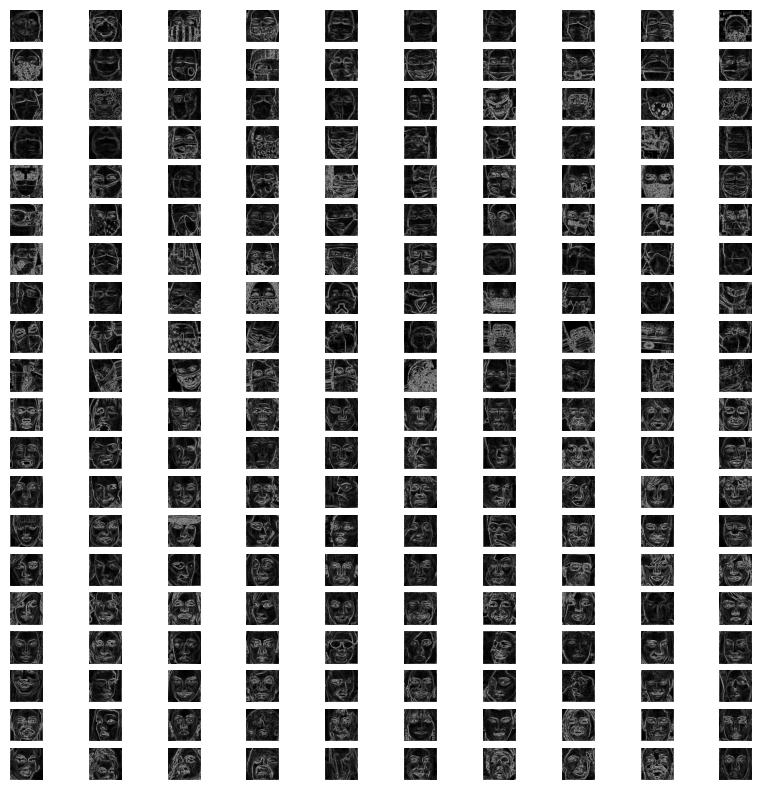

In [130]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)): # Loop through each image and do preprocessing
    img = equalize_histogram(data[i])
    img_proc = convolution(img, kernel)
    img_proc1 = medianfilter(img_proc, np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))
    img_proc2 = gaussian_blur(img_proc1)
    img_proc3 = edgedetection(img_proc2, Prewittx, Prewitty)
    img_proc3 = img_proc3.astype(np.uint8)
    dataPreprocessed.append(img_proc3)

plt.figure(figsize=(10, 10))
for i in range(len(dataPreprocessed)):
    plt.subplot(20, 10, i + 1)
    plt.imshow(dataPreprocessed[i], cmap='gray')
    plt.axis('off')

plt.show()

Kode ini berfungsi untuk menampilkan visualisasi gambar hasil preprocessing yang sudah dikonversi menjadi array NumPy bersama dengan label dan nama file masing-masing. Pertama, data gambar (`dataPreprocessed`), label (`labels`), dan nama file (`file_name`) diubah menjadi array NumPy agar mudah diolah.

Selanjutnya, kode mengambil semua label unik yang ada di dataset. Untuk setiap label unik tersebut, kode memilih 20 gambar pertama yang sesuai dengan label tersebut.

Setelah itu, dibuat sebuah figure dengan ukuran lebar yang cukup besar untuk menampilkan 20 gambar secara berjajar dalam 2 baris dan 10 kolom. Setiap subplot menampilkan gambar grayscale dengan judul berupa nama file gambar. Sumbu pada gambar dinonaktifkan agar tampilan lebih bersih. Judul utama figure menunjukkan label kelas yang sedang ditampilkan. Visualisasi ini membantu memeriksa hasil preprocessing dan distribusi gambar per kelas dengan jelas.


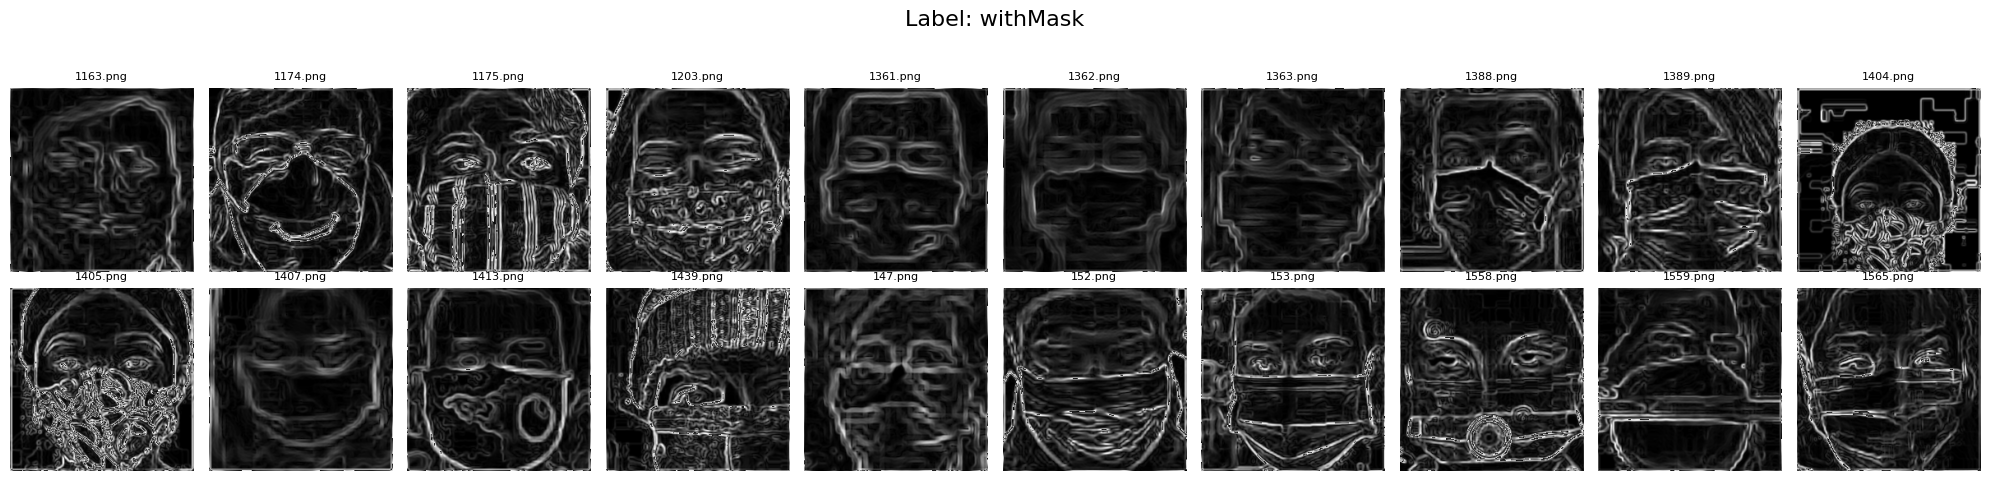

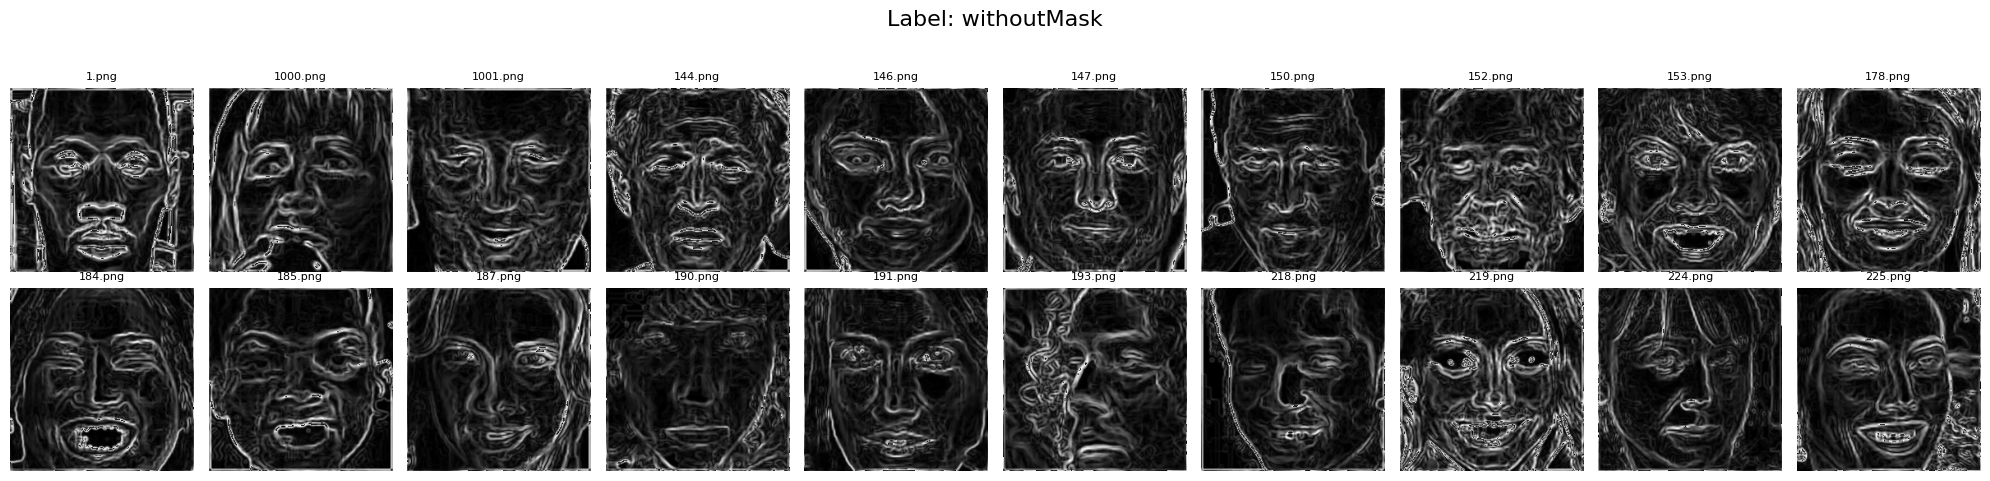

In [131]:
# Konversi ke array
dataPreprocessed = np.array(dataPreprocessed)
labels = np.array(labels)
file_name = np.array(file_name)

# Ambil semua label unik
unique_labels = np.unique(labels)

# Tampilkan 20 gambar pertama untuk setiap label
for label in unique_labels:
    # Ambil indeks yang cocok dengan label
    idx = np.where(labels == label)[0][:20]  # ambil 20 pertama saja
    
    # Ukuran figure
    plt.figure(figsize=(20, 5))
    plt.suptitle(f"Label: {label}", fontsize=16)

    for i, img_idx in enumerate(idx):
        plt.subplot(2, 10, i+1)
        plt.imshow(dataPreprocessed[img_idx], cmap='gray')
        plt.title(file_name[img_idx], fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

### Feature Extraction

Kode ini berfungsi untuk menghitung matriks *Gray Level Co-occurrence Matrix* (GLCM) dari sebuah citra grayscale berdasarkan sudut tertentu (derajat) yang ditentukan pengguna. Fungsi `glcm(image, derajat)` menerima dua input: gambar (`image`) dan sudut (`derajat`) dalam derajat, yang hanya boleh bernilai 0, 45, 90, atau 135.

Berdasarkan nilai `derajat`, fungsi mengkonversinya ke radian dan membuat list `angles` yang akan digunakan pada fungsi `graycomatrix` dari pustaka skimage untuk menghitung GLCM pada jarak 1 piksel dan sudut tersebut. Fungsi mengembalikan matriks GLCM yang sudah dinormalisasi dan simetris, yang merepresentasikan frekuensi kemunculan pasangan intensitas piksel tertentu pada arah dan jarak tertentu dalam citra. Matriks ini biasa digunakan untuk ekstraksi fitur tekstur pada citra.


In [132]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Fungsi `correlation` ini berfungsi untuk menghitung nilai **koefisien korelasi tekstur** dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi menerima input `matriks` hasil GLCM, lalu memanggil fungsi `graycoprops` dari pustaka skimage dengan parameter `'correlation'` untuk mendapatkan nilai korelasi tekstur. Nilai korelasi ini mengukur seberapa erat hubungan linear antar intensitas piksel dalam citra, yang berguna untuk mendeskripsikan pola tekstur pada gambar. Fungsi kemudian mengembalikan nilai korelasi tersebut sebagai angka tunggal.


In [133]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi `dissimilarity` ini berfungsi untuk menghitung nilai **dissimilarity** dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi menerima input `matriks` hasil GLCM, lalu menggunakan fungsi `graycoprops` dari pustaka skimage dengan parameter `'dissimilarity'` untuk mendapatkan ukuran ketidaksamaan tekstur. Nilai dissimilarity mengukur seberapa berbeda intensitas piksel yang berdekatan dalam citra, semakin besar nilainya berarti tekstur semakin tidak seragam. Fungsi mengembalikan nilai dissimilarity sebagai angka tunggal.


In [134]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi `homogenity` ini berfungsi untuk menghitung nilai **homogenitas** dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi menerima input `matriks` hasil GLCM, lalu memanggil fungsi `graycoprops` dari pustaka skimage dengan parameter `'homogeneity'` untuk mendapatkan ukuran keseragaman tekstur dalam citra. Nilai homogenitas yang tinggi menunjukkan bahwa intensitas piksel dalam citra relatif seragam atau konsisten. Fungsi mengembalikan nilai homogenitas sebagai angka tunggal.


In [135]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi `contrast` ini berfungsi untuk menghitung nilai **kontras** dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi menerima input `matriks` hasil GLCM, lalu menggunakan fungsi `graycoprops` dari pustaka skimage dengan parameter `'contrast'` untuk mengukur tingkat variasi intensitas piksel dalam citra. Nilai kontras yang tinggi menunjukkan perbedaan intensitas yang besar antara piksel-piksel yang berdekatan, yang mengindikasikan tekstur dengan detail tajam atau tepi yang kuat. Fungsi mengembalikan nilai kontras sebagai angka tunggal.


In [136]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi `ASM` ini berfungsi untuk menghitung **Angular Second Moment (ASM)** dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi menerima input `matriks` hasil GLCM, lalu memanggil fungsi `graycoprops` dari pustaka skimage dengan parameter `'ASM'`. ASM adalah ukuran energi tekstur yang menunjukkan keseragaman atau kerapatan pola dalam citra; nilai ASM yang tinggi menandakan tekstur yang sangat seragam atau teratur. Fungsi mengembalikan nilai ASM sebagai angka tunggal.


In [137]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi `energy` ini berfungsi untuk menghitung nilai **energi** dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi menerima input `matriks` hasil GLCM, kemudian menggunakan fungsi `graycoprops` dari pustaka skimage dengan parameter `'energy'` untuk mengukur kekuatan atau intensitas pola tekstur dalam citra. Energi adalah akar kuadrat dari Angular Second Moment (ASM) dan nilai yang tinggi menunjukkan tekstur yang teratur dan homogen. Fungsi mengembalikan nilai energi sebagai angka tunggal.


In [138]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi `entropyGlcm` ini berfungsi untuk menghitung **entropi** dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi menerima input `matriks` hasil GLCM, lalu meratakan matriks menjadi satu dimensi menggunakan `.ravel()`. Selanjutnya, fungsi `entropy` dari pustaka SciPy digunakan untuk menghitung entropi, yang mengukur tingkat ketidakteraturan atau kompleksitas tekstur dalam citra. Nilai entropi yang tinggi menunjukkan tekstur yang lebih acak dan kompleks. Fungsi mengembalikan nilai entropi sebagai angka tunggal.


In [139]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Kode ini berfungsi untuk menghitung matriks GLCM pada empat arah sudut berbeda (0°, 45°, 90°, dan 135°) untuk setiap gambar yang sudah dipreproses di `dataPreprocessed`. Dalam loop:

* Untuk setiap gambar, fungsi `glcm` dipanggil dengan sudut yang berbeda.
* Hasil matriks GLCM untuk masing-masing sudut disimpan ke dalam list terpisah: `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`.

Tujuannya adalah memperoleh representasi tekstur dari setiap gambar di berbagai arah, yang nantinya bisa digunakan untuk ekstraksi fitur tekstur yang lebih lengkap dan akurat.

In [140]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode ini berfungsi untuk mendefinisikan list kosong yang akan digunakan untuk menyimpan nilai fitur tekstur hasil ekstraksi dari matriks GLCM pada setiap sudut (0°, 45°, 90°, dan 135°). Masing-masing fitur tekstur yang disiapkan adalah:

* **Kontras (contrast)**
* **Dissimilarity**
* **Homogenitas (homogeneity)**
* **Entropi (entropy)**
* **Angular Second Moment (ASM)**
* **Energi (energy)**
* **Korelasi (correlation)**

Setiap fitur memiliki empat list terpisah sesuai sudut pengambilan matriks GLCM, sehingga nantinya setiap list akan berisi nilai fitur tekstur untuk semua gambar pada sudut tertentu. Ini memudahkan pengorganisasian data fitur berdasarkan arah sudut.


In [141]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Kode ini berfungsi untuk mengekstrak fitur **korelasi** dari matriks GLCM pada setiap sudut (0°, 45°, 90°, dan 135°) untuk seluruh gambar yang sudah dipreproses.

Dalam loop `for`:

* Untuk setiap gambar, fungsi `correlation()` dipanggil dengan matriks GLCM dari sudut masing-masing (`Derajat0[i]`, `Derajat45[i]`, dll).
* Nilai korelasi yang dihasilkan kemudian dimasukkan ke dalam list yang sesuai (`correlation0`, `correlation45`, `correlation90`, `correlation135`).

Hasil akhirnya adalah empat list yang berisi nilai korelasi tekstur untuk setiap gambar di keempat sudut tersebut.

In [142]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode ini berfungsi untuk mengekstrak fitur **kontras** dari matriks GLCM pada empat sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam dataset `data`.

Pada setiap iterasi:

* Fungsi `contrast()` dipanggil untuk matriks GLCM pada masing-masing sudut.
* Nilai kontras yang diperoleh kemudian disimpan ke dalam list yang sesuai (`Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`).

Hasil akhirnya adalah empat list yang berisi nilai kontras tekstur dari semua gambar di setiap sudut tersebut, yang bisa digunakan untuk analisis atau pelatihan model.


In [143]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode ini berfungsi untuk mengekstrak fitur **dissimilarity** dari matriks GLCM pada empat sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam dataset `data`.

Pada setiap iterasi:

* Fungsi `dissimilarity()` dipanggil untuk matriks GLCM di masing-masing sudut.
* Nilai dissimilarity yang didapat kemudian dimasukkan ke dalam list yang sesuai (`dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`).

Hasilnya adalah empat list berisi nilai fitur dissimilarity untuk semua gambar di keempat arah tersebut.


In [144]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode ini berfungsi untuk mengekstrak fitur **homogenitas** dari matriks GLCM pada empat sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam dataset `data`.

Pada setiap iterasi:

* Fungsi `homogenity()` dipanggil untuk matriks GLCM pada masing-masing sudut.
* Nilai homogenitas yang dihasilkan disimpan ke dalam list yang sesuai (`homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`).

Hasilnya adalah empat list yang berisi nilai homogenitas tekstur untuk semua gambar di keempat sudut tersebut, berguna untuk analisis atau pemrosesan lebih lanjut.

In [145]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode ini berfungsi untuk mengekstrak fitur **entropi** dari matriks GLCM pada empat sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam dataset `data`.

Pada setiap iterasi:

* Fungsi `entropyGlcm()` dipanggil untuk matriks GLCM pada masing-masing sudut.
* Nilai entropi yang diperoleh kemudian disimpan ke dalam list yang sesuai (`entropy0`, `entropy45`, `entropy90`, dan `entropy135`).

Hasilnya adalah empat list berisi nilai entropi tekstur untuk semua gambar di keempat arah tersebut, yang menunjukkan tingkat kompleksitas atau ketidakteraturan tekstur.


In [146]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode ini berfungsi untuk mengekstrak fitur **Angular Second Moment (ASM)** dari matriks GLCM pada empat sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam dataset `data`.

Pada setiap iterasi:

* Fungsi `ASM()` dipanggil dengan matriks GLCM pada masing-masing sudut.
* Nilai ASM yang didapatkan kemudian dimasukkan ke dalam list yang sesuai (`ASM0`, `ASM45`, `ASM90`, dan `ASM135`).

Hasilnya adalah empat list berisi nilai ASM untuk semua gambar pada keempat arah tersebut, yang mencerminkan tingkat keseragaman tekstur dalam citra.


In [147]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode ini berfungsi untuk mengekstrak fitur **energi** dari matriks GLCM pada empat sudut (0°, 45°, 90°, dan 135°) untuk setiap gambar dalam dataset `data`.

Pada setiap iterasi:

* Fungsi `energy()` dipanggil dengan matriks GLCM pada masing-masing sudut.
* Nilai energi yang diperoleh kemudian dimasukkan ke dalam list yang sesuai (`energy0`, `energy45`, `energy90`, dan `energy135`).

Hasil akhirnya adalah empat list yang berisi nilai energi tekstur dari semua gambar di keempat arah tersebut, yang mengukur kekuatan atau intensitas tekstur.


In [148]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

Kode ini berfungsi untuk menyusun semua fitur tekstur hasil ekstraksi dari citra ke dalam sebuah **DataFrame** menggunakan pandas, kemudian menyimpannya dalam format file CSV.

Penjelasan langkah-langkahnya:

* Semua list fitur (seperti `Kontras0`, `homogenity45`, `dissimilarity90`, dll) beserta `file_name` dan `labels` dikumpulkan ke dalam sebuah dictionary `dataTable`, dengan nama kolom yang sesuai.
* Dictionary ini kemudian dikonversi menjadi DataFrame `df` dengan `pd.DataFrame(dataTable)`.
* DataFrame tersebut disimpan ke file CSV bernama `'hasil_ekstraksi_1.csv'` tanpa menyimpan index.
* File CSV tersebut kemudian dibaca kembali ke variabel `hasilEkstrak` dan ditampilkan sebagai output.

Ini memudahkan penyimpanan dan analisis data fitur tekstur secara terstruktur menggunakan format tabel.


In [149]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1163.png,withMask,238.866091,384.950351,188.760410,406.025438,0.245614,0.176772,0.251487,0.171245,...,0.001196,0.000771,0.034056,0.028335,0.034580,0.027760,0.872431,0.785708,0.900445,0.773977
1,1174.png,withMask,998.514254,1425.849605,1113.553151,1399.665648,0.184465,0.129826,0.182824,0.129093,...,0.000898,0.000645,0.029987,0.025278,0.029964,0.025407,0.764246,0.656275,0.732897,0.662578
2,1175.png,withMask,2587.147722,2951.794969,1110.661935,2987.619297,0.115266,0.078709,0.134051,0.081766,...,0.000345,0.000229,0.017517,0.014961,0.018567,0.015139,0.618515,0.561884,0.835829,0.556665
3,1203.png,withMask,695.916780,1349.887470,871.368594,1202.322407,0.148955,0.093295,0.131281,0.096743,...,0.000342,0.000262,0.019450,0.015855,0.018483,0.016171,0.840751,0.686304,0.799770,0.720638
4,1361.png,withMask,194.071709,372.823343,202.955697,366.501941,0.304724,0.206292,0.289142,0.203644,...,0.001641,0.001109,0.041311,0.033551,0.040503,0.033305,0.897457,0.793438,0.895259,0.796915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,967.png,withoutMask,480.479560,1027.736733,727.836483,1003.762694,0.185081,0.151536,0.212091,0.144783,...,0.002658,0.002051,0.047781,0.046004,0.051558,0.045285,0.861908,0.695485,0.788697,0.702638
196,972.png,withoutMask,1521.206859,2152.042711,1331.989470,2185.003881,0.108195,0.079192,0.115659,0.076310,...,0.000235,0.000162,0.014786,0.012840,0.015323,0.012724,0.749685,0.643874,0.781094,0.638455
197,973.png,withoutMask,957.904929,1407.547105,875.016115,1309.404452,0.117725,0.082197,0.118191,0.083579,...,0.000315,0.000233,0.017786,0.015291,0.017751,0.015249,0.792591,0.690360,0.810594,0.711916
198,998.png,withoutMask,1933.484005,2550.909288,1934.442805,2685.238633,0.106602,0.081747,0.113501,0.082081,...,0.000316,0.000235,0.017383,0.015208,0.017767,0.015314,0.708643,0.612140,0.710600,0.591700


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

Kode ini berfungsi untuk **melakukan seleksi fitur** berdasarkan korelasi antar fitur dan menampilkan visualisasi korelasi fitur yang terpilih.

Penjelasan langkah-langkahnya:

* Menghitung matriks korelasi antar fitur dengan `hasilEkstrak.drop(columns=['Label','Filename']).corr()`, mengabaikan kolom label dan filename.
* Menggunakan threshold korelasi absolut 0.95 untuk menyaring fitur yang sangat berkorelasi satu sama lain (redundan).
* Melalui loop, fitur yang korelasinya dengan fitur sebelumnya melebihi threshold akan di-nonaktifkan (tidak dipilih) dengan mengubah nilai pada array `columns` menjadi `False`.
* Fitur yang masih `True` di `columns` dipilih sebagai fitur terpilih (`select`).
* Membuat subset data fitur (`x_new`) hanya dengan fitur yang terpilih.
* Mendefinisikan variabel target `y` sebagai kolom label.
* Terakhir, membuat heatmap korelasi dari fitur yang terpilih menggunakan seaborn (`sns.heatmap`), untuk visualisasi hubungan antar fitur secara jelas.

Jadi, ini adalah proses **feature selection berbasis korelasi** untuk mengurangi fitur yang redundan sekaligus menampilkan korelasi fitur terpilih secara visual.


<Axes: >

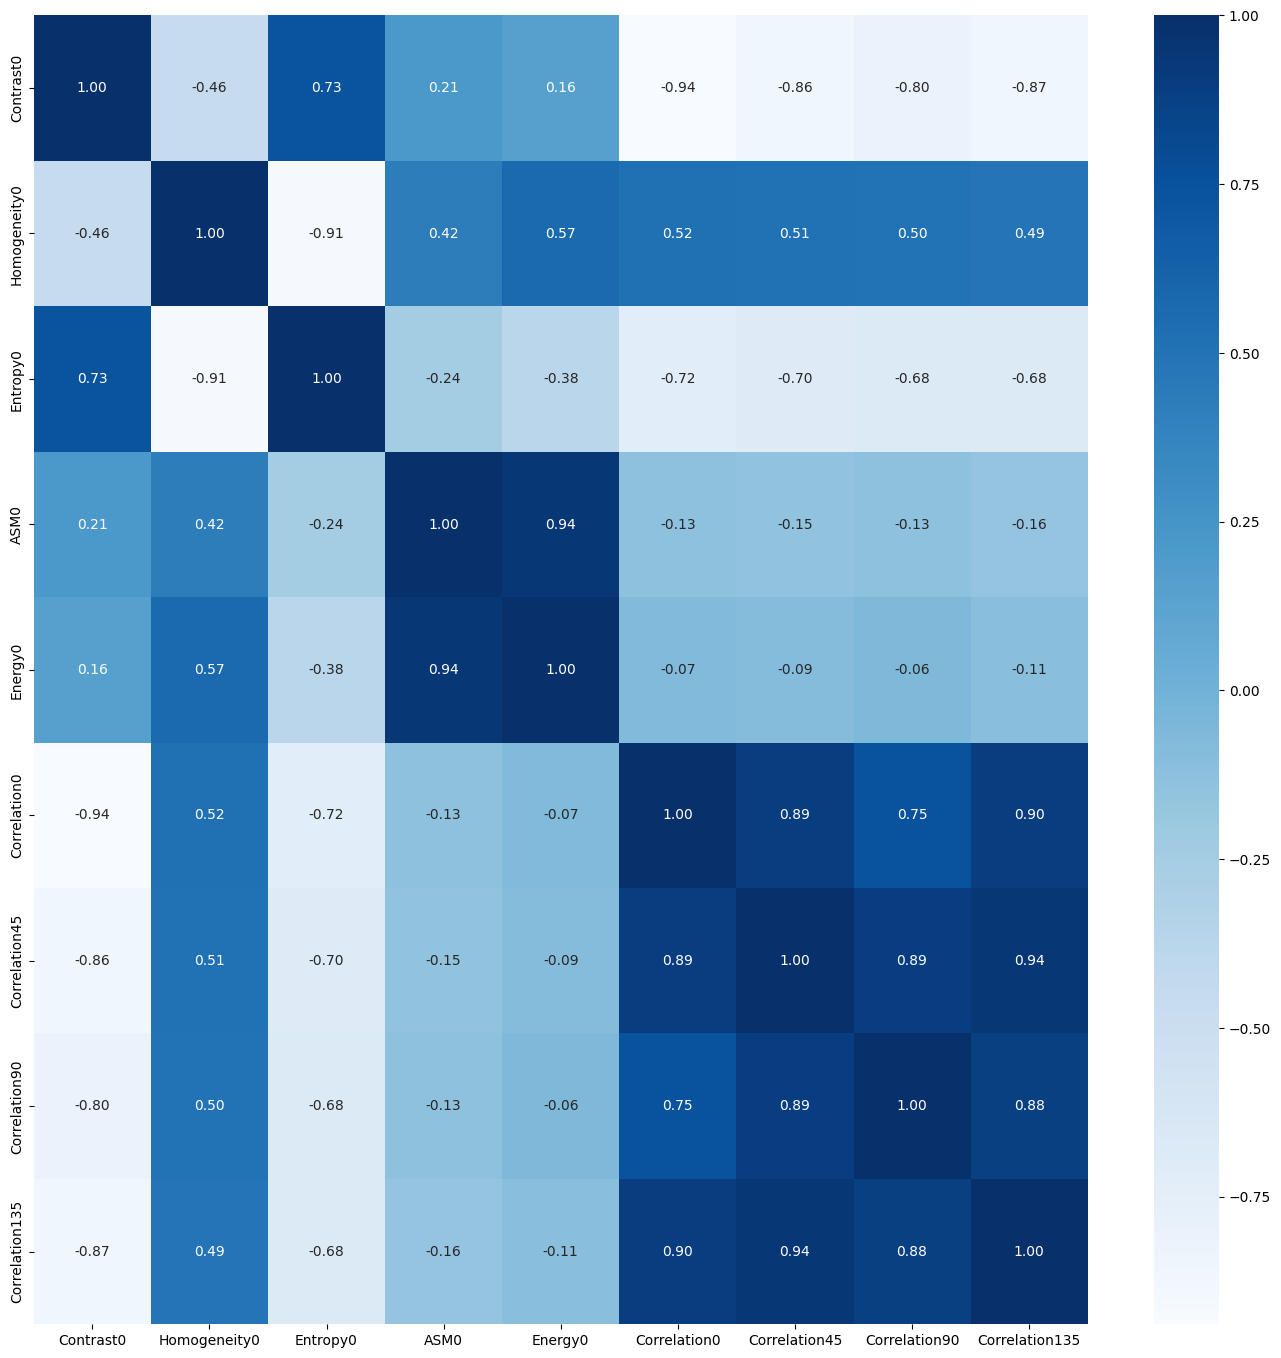

In [150]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

Kode ini berfungsi untuk membagi dataset fitur (`x_new`) dan target label (`y`) menjadi data **latih (training)** dan **uji (testing)** menggunakan fungsi `train_test_split` dari scikit-learn.

Penjelasan detail:

* `test_size=0.2` berarti 20% data dialokasikan sebagai data uji, dan sisanya 80% sebagai data latih.
* `random_state=42` memastikan pembagian data bersifat reproducible, jadi hasil split akan sama setiap kali dijalankan.
* Setelah pembagian, kode mencetak ukuran (jumlah baris dan kolom) dari dataset latih (`X_train`) dan dataset uji (`X_test`) untuk memastikan proporsi data sudah benar.

Ini adalah langkah penting untuk mempersiapkan data sebelum melatih dan menguji model machine learning.


In [151]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 9)
(40, 9)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

Kode ini berfungsi untuk melakukan **normalisasi fitur** pada dataset training dan testing dengan metode **standarisasi (mean = 0, std = 1)** menggunakan mean dan standar deviasi dari data training.

Penjelasan langkah-langkahnya:

* Menghitung rata-rata (`mean()`) dan standar deviasi (`std()`) dari fitur pada data training (`X_train`).
* Mengurangi setiap nilai fitur di `X_train` dan `X_test` dengan mean data training, lalu membaginya dengan standar deviasi data training.
* Dengan cara ini, data fitur diubah agar memiliki distribusi dengan rata-rata 0 dan deviasi standar 1 berdasarkan data training.
* Penting menggunakan statistik dari data training untuk menghindari kebocoran informasi (data leakage) ke data testing.

Normalisasi ini membantu model machine learning agar fitur memiliki skala yang sama dan mempercepat proses training serta meningkatkan performa model.

In [152]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

Kode ini berfungsi untuk menyiapkan fungsi dan model klasifikasi untuk evaluasi dan pelatihan:

1. **Fungsi `generateClassificationReport`**
   Fungsi ini menerima data label asli (`y_true`) dan prediksi model (`y_pred`) lalu menampilkan:

   * Laporan klasifikasi lengkap (precision, recall, f1-score) dari `classification_report`.
   * Matriks kebingungan (confusion matrix).
   * Akurasi keseluruhan prediksi.

2. **Pendefinisian Model Klasifikasi**

   * `rf`: Random Forest dengan 5 pohon keputusan (`n_estimators=5`), cocok untuk data tabular dengan performa baik.
   * `svm`: Support Vector Machine dengan kernel RBF, cocok untuk klasifikasi non-linear.
   * `knn`: K-Nearest Neighbors dengan 5 tetangga, sederhana dan efektif untuk data kecil sampai sedang.

Model ini siap dilatih dan diuji menggunakan dataset yang telah dipersiapkan.


In [153]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

Kode ini berfungsi untuk melatih model Random Forest, melakukan prediksi, dan mengevaluasi performanya pada data training dan testing:

* **Melatih model Random Forest** (`rf.fit`) menggunakan fitur dan label training (`X_train`, `y_train`).
* **Prediksi dan evaluasi pada data training**:
  Membuat prediksi label untuk data training dan menampilkan laporan klasifikasi lengkap, matriks kebingungan, serta akurasi dengan fungsi `generateClassificationReport`. Ini untuk mengukur seberapa baik model menghafal data training.
* **Prediksi dan evaluasi pada data testing**:
  Membuat prediksi untuk data testing dan mengevaluasi performa model pada data baru yang tidak pernah dilihat sebelumnya, guna mengetahui kemampuan generalisasi model.

Hasilnya memberikan gambaran seberapa baik model bekerja dan apakah terjadi overfitting atau underfitting.

In [154]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

    withMask       0.99      0.90      0.94        79
 withoutMask       0.91      0.99      0.95        81

    accuracy                           0.94       160
   macro avg       0.95      0.94      0.94       160
weighted avg       0.95      0.94      0.94       160

[[71  8]
 [ 1 80]]
Accuracy: 0.94375

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.80      0.76      0.78        21
 withoutMask       0.75      0.79      0.77        19

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.78        40

[[16  5]
 [ 4 15]]
Accuracy: 0.775


### Train SVM Classifier

Kode ini berfungsi untuk melatih model Support Vector Machine (SVM), melakukan prediksi, dan mengevaluasi performanya pada data training dan testing:

* **Melatih model SVM** (`svm.fit`) dengan data training (`X_train`, `y_train`).
* **Prediksi dan evaluasi pada data training**:
  Membuat prediksi label untuk data training dan menampilkan laporan klasifikasi, matriks kebingungan, serta akurasi untuk mengukur kemampuan model mengenali data yang sudah dilatih.
* **Prediksi dan evaluasi pada data testing**:
  Melakukan prediksi pada data testing dan menilai performa model terhadap data yang belum pernah dilihat sebelumnya, guna menguji kemampuan generalisasi.

Dengan langkah ini, kamu bisa melihat efektivitas model SVM dibandingkan dengan model lain seperti Random Forest.


In [155]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

    withMask       0.90      0.81      0.85        79
 withoutMask       0.83      0.91      0.87        81

    accuracy                           0.86       160
   macro avg       0.87      0.86      0.86       160
weighted avg       0.87      0.86      0.86       160

[[64 15]
 [ 7 74]]
Accuracy: 0.8625

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.83      0.95      0.89        21
 withoutMask       0.94      0.79      0.86        19

    accuracy                           0.88        40
   macro avg       0.89      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40

[[20  1]
 [ 4 15]]
Accuracy: 0.875


### Train KNN Classifier

Kode ini berfungsi untuk melatih model K-Nearest Neighbors (KNN), melakukan prediksi, dan mengevaluasi performanya pada data training dan testing:

* **Melatih model KNN** (`knn.fit`) menggunakan data training (`X_train`, `y_train`).
* **Prediksi dan evaluasi pada data training**:
  Membuat prediksi label pada data training dan menampilkan laporan klasifikasi, matriks kebingungan, serta akurasi untuk mengukur kemampuan model mengenali data yang sudah dilatih.
* **Prediksi dan evaluasi pada data testing**:
  Melakukan prediksi pada data testing dan mengevaluasi performa model terhadap data baru yang belum pernah dilihat sebelumnya, sehingga bisa mengukur kemampuan generalisasi model.

Dengan proses ini, kamu dapat membandingkan performa KNN dengan model lain seperti Random Forest dan SVM.


In [156]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

    withMask       0.91      0.80      0.85        79
 withoutMask       0.82      0.93      0.87        81

    accuracy                           0.86       160
   macro avg       0.87      0.86      0.86       160
weighted avg       0.87      0.86      0.86       160

[[63 16]
 [ 6 75]]
Accuracy: 0.8625

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.81      0.81      0.81        21
 withoutMask       0.79      0.79      0.79        19

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40

[[17  4]
 [ 4 15]]
Accuracy: 0.8


## Evaluation With Confusion Matrix

Kode ini berfungsi untuk menampilkan visualisasi matriks kebingungan (confusion matrix) dari hasil prediksi model klasifikasi pada data uji. Fungsi `plot_confusion_matrix` menerima label asli (`y_true`), label prediksi (`y_pred`), dan judul grafik (`title`), kemudian menghitung matriks kebingungan menggunakan `confusion_matrix` dari scikit-learn dan menampilkannya dengan warna biru menggunakan `ConfusionMatrixDisplay`. Setelah itu, fungsi ini dipanggil tiga kali untuk masing-masing model klasifikasi yang telah dilatih, yaitu Random Forest, SVM, dan KNN, sehingga memudahkan perbandingan performa ketiga model melalui visualisasi confusion matrix pada data testing.


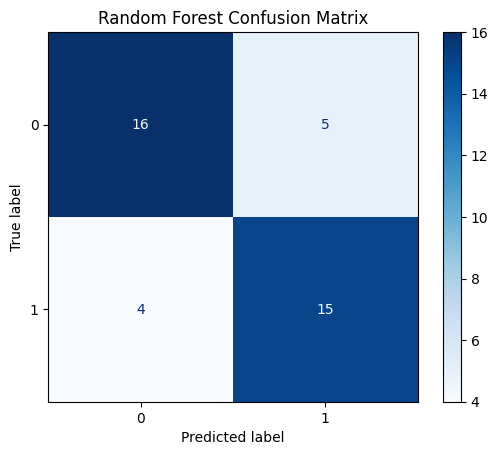

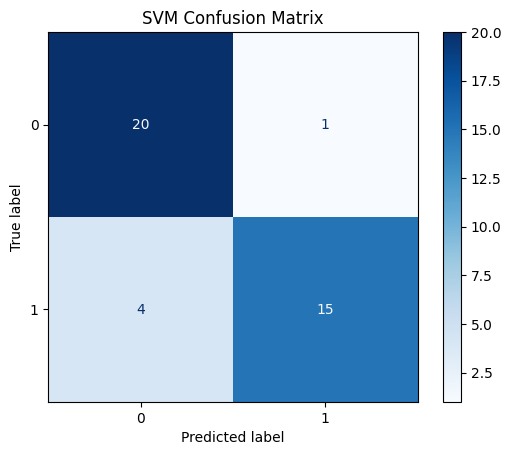

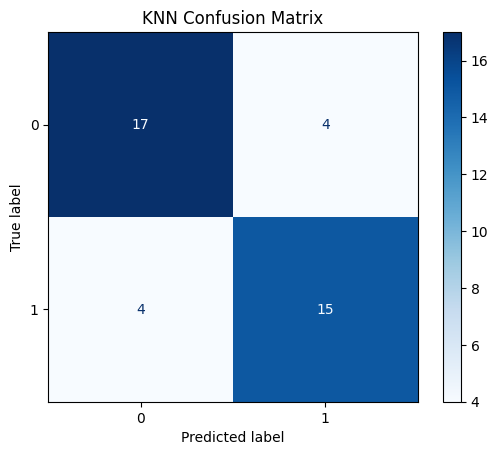

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")